In [1]:
import os
import setGPU
# edit depending on where Vivado is installed:
# os.environ['PATH'] = '/<Xilinx installation directory>/Vivado/<version>/bin:' + os.environ['PATH']
os.environ['PATH'] = '/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
import tensorflow as tf
from qkeras.utils import _add_supported_quantized_objects
import hls4ml
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model

setGPU: Setting GPU to: 1


/scratch/data/jduarte/garnet/hls4ml/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
def yaml_load(config):
    with open(config) as stream:
        param = yaml.safe_load(stream)
        

def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

In [3]:
model_file_path = 'model_QInteractionNetwork_nconst_8_nbits_8.h5'

In [4]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)    

model = load_model(model_file_path, custom_objects=co)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
batchnorm (BatchNormalization)  (None, 8, 3)         12          input[0][0]                      
__________________________________________________________________________________________________
permute (Permute)               (None, 3, 8)         0           batchnorm[0][0]                  
__________________________________________________________________________________________________
tmul_1 (Conv1D)                 (None, 3, 56)        448         permute[0][0]                    
______________________________________________________________________________________________

In [121]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model']['ReuseFactor'] = 1
config['Model']['Strategy'] = 'Latency'
config['Model']['Precision'] = 'ap_fixed<32,16>'
#config['SkipOptimizers'] = ['optimize_pointwise_conv']
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = False
    if 'input' in layer:
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<32,16>'
    if 'batchnorm' in layer:
        config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<32,16>'
        config['LayerName'][layer]['Precision']['default'] = 'ap_fixed<32,16>'
        config['LayerName'][layer]['Precision']['scale'] = 'ap_fixed<32,16>'
        config['LayerName'][layer]['Precision']['bias'] = 'ap_fixed<32,16>'
    if 'linear' in layer:
        config['LayerName'][layer]['Precision'] = {}
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<9,6>'
        config['LayerName'][layer]['Precision']['default'] = 'ap_fixed<9,6>'
    if 'tmul' in layer and 'linear' not in layer:
        config['LayerName'][layer]['Precision']['weight'] = 'ap_uint<1>'
        config['LayerName'][layer]['Precision']['bias'] = 'ap_uint<1>'
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<9,6>'
        config['LayerName'][layer]['Precision']['default'] = 'ap_fixed<9,6>'
    if 'q_activation' in layer:
        config['LayerName'][layer]['Precision']['default'] = 'ap_fixed<9,6>'
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<8,3,AP_RND,AP_SAT>'
    if 'q_conv1d' in layer:
        config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<9,6>'
        config['LayerName'][layer]['Precision']['default'] = 'ap_fixed<9,6>'
    if 'q_dense' in layer:
        config['LayerName'][layer]['accum_t'] = 'ap_fixed<32,16>'
        config['LayerName'][layer]['Precision']['result'] = 'ap_fixed<9,6>'
        config['LayerName'][layer]['Precision']['default'] = 'ap_fixed<9,6>'

cfg = hls4ml.converters.create_config(part='xc7z020clg400-1')
cfg['HLSConfig'] = config
cfg['IOType'] = 'io_stream'
cfg['Backend'] = 'Vivado'
cfg['ClockPeriod'] = 5
cfg['KerasModel'] = model
cfg['OutputDir'] = 'hls_output'

print("-----------------------------------")
print_dict(cfg)
print("-----------------------------------")

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Model
Topology:
Layer name: input, layer type: Input
Layer name: batchnorm, layer type: BatchNormalization
Layer name: tmul_1, layer type: Conv1D
  -> Activation (linear), layer name: tmul_1
Layer name: tmul_2, layer type: Conv1D
  -> Activation (linear), layer name: tmul_2
Layer name: concatenate, layer type: Concatenate
Layer name: q_conv1d, layer type: QConv1D
Layer name: q_activation, layer type: QActivation
Layer name: q_conv1d_1, layer type: QConv1D
Layer name: q_activation_1, layer type: QActivation
Layer name: q_conv1d_2, layer type: QConv1D
Layer name: q_activation_2, layer type: QActivation
Layer name: tmul_3, layer type: Conv1D
  -> Activation (linear), layer name: tmul_3
Layer name: concatenate_1, layer type: Concatenate
Layer name: q_conv1d_3, layer type: QConv1D
Layer name: q_activation_3, layer type: QActivation
Layer name: q_conv1d_4, layer type: QConv1D
Layer name: q_activation_4, layer type: QActivation
Layer name: q_conv1d_5, layer type: QConv1D
Layer na

Done


In [11]:
import numpy as np
import h5py
import os

#Data PATH
TEST_PATH = '/xilinx/scratch/hls4ml_LHCjet_150p_val/'

first=True
for file in os.listdir(TEST_PATH):
  print("Appending %s" %file)

  with h5py.File(TEST_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]
        target = data['jets'][:,-6:-1]
        featurenames = data.get('jetFeatureNames')
        featurenames = data.get('particleFeatureNames')
        images = data.get('jetImage')

    else:
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )
                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)

Appending jetImage_7_150p_0_10000.h5
Appending jetImage_7_150p_10000_20000.h5
Appending jetImage_7_150p_20000_30000.h5
Appending jetImage_7_150p_30000_40000.h5
Appending jetImage_7_150p_40000_50000.h5
Appending jetImage_7_150p_50000_60000.h5
Appending jetImage_7_150p_60000_70000.h5
Appending jetImage_7_150p_70000_80000.h5
Appending jetImage_7_150p_80000_90000.h5
Appending jetImage_8_150p_0_10000.h5
Appending jetImage_8_150p_10000_20000.h5
Appending jetImage_8_150p_20000_30000.h5
Appending jetImage_8_150p_30000_40000.h5
Appending jetImage_8_150p_40000_50000.h5
Appending jetImage_8_150p_50000_60000.h5
Appending jetImage_8_150p_60000_70000.h5
Appending jetImage_8_150p_70000_80000.h5
Appending jetImage_8_150p_80000_90000.h5
Appending jetImage_9_150p_0_10000.h5
Appending jetImage_9_150p_10000_20000.h5
Appending jetImage_9_150p_20000_30000.h5
Appending jetImage_9_150p_30000_40000.h5
Appending jetImage_9_150p_50000_60000.h5
Appending jetImage_9_150p_60000_70000.h5
Appending jetImage_9_150p_70

In [12]:
from einops import rearrange, reduce, repeat

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

# Filter out constituents with Pt<2GeV
Ptmin = 2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1

# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]

# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]


print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


# Shuffles Jet Constituents because L1 constituents are not Pt ordered to begin with
print("Before --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])
jetConstituent = jetConstituent[ : , np.random.permutation(nconstit), : ]
print("After --->> jetConstituent[0,0:4,0] = ",jetConstituent[0,0:4,0])

Number of jets = 260000
Number of constituents = 8
Number of features = 3
Before --->> jetConstituent[0,0:4,0] =  [86.5259   73.438774 58.09876  57.977833]
After --->> jetConstituent[0,0:4,0] =  [49.31843  52.168007 30.947245 57.977833]


In [104]:
njet = 10000
X_test = np.ascontiguousarray(jetConstituent)[:njet]
Y_test = target[:njet]

In [116]:
Y_predict = model.predict(X_test)
Y_hls = hls_model.predict(X_test)

In [117]:
_, hls_trace = hls_model.trace(X_test)

Recompiling myproject with tracing
Writing HLS project
Done


In [118]:
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

Processing input in Keras model...
Processing batchnorm in Keras model...
Processing permute in Keras model...
Processing tmul_1 in Keras model...
Processing tmul_2 in Keras model...
Processing concatenate in Keras model...
Processing permute_1 in Keras model...
Processing q_conv1d in Keras model...
Processing q_activation in Keras model...
Processing q_conv1d_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing q_conv1d_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing permute_2 in Keras model...
Processing tmul_3 in Keras model...
Processing concatenate_1 in Keras model...
Processing permute_3 in Keras model...
Processing q_conv1d_3 in Keras model...
Processing q_activation_3 in Keras model...
Processing q_conv1d_4 in Keras model...
Processing q_activation_4 in Keras model...
Processing q_conv1d_5 in Keras model...
Processing q_activation_5 in Keras model...
Processing flatten in Keras model...
Processing q_dense in Keras model...
Proces

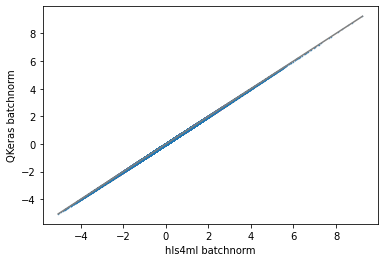

<Figure size 432x288 with 0 Axes>

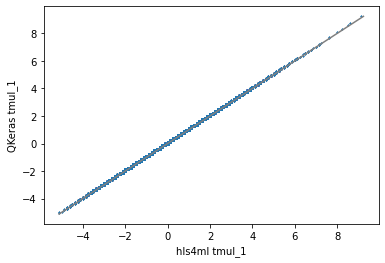

<Figure size 432x288 with 0 Axes>

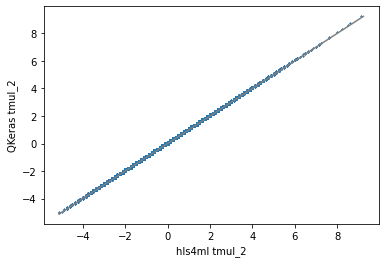

<Figure size 432x288 with 0 Axes>

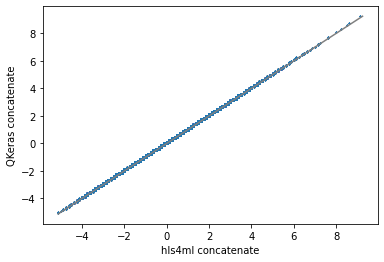

<Figure size 432x288 with 0 Axes>

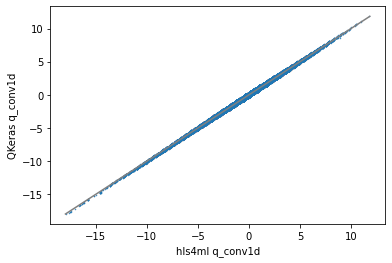

<Figure size 432x288 with 0 Axes>

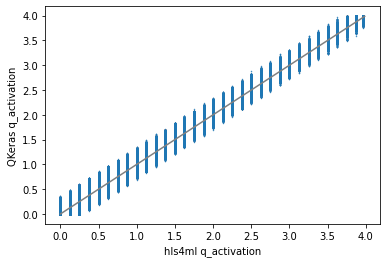

<Figure size 432x288 with 0 Axes>

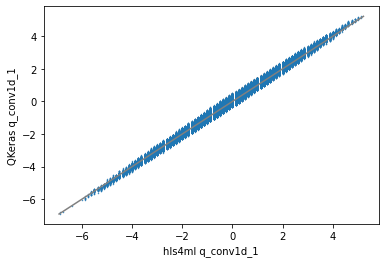

<Figure size 432x288 with 0 Axes>

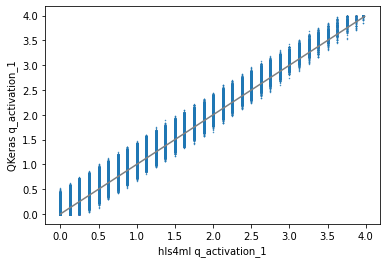

<Figure size 432x288 with 0 Axes>

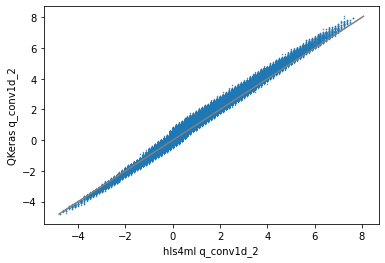

<Figure size 432x288 with 0 Axes>

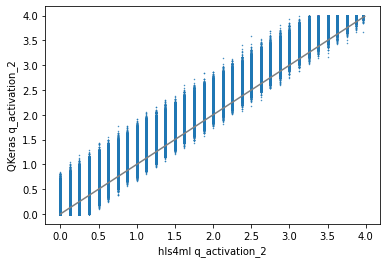

<Figure size 432x288 with 0 Axes>

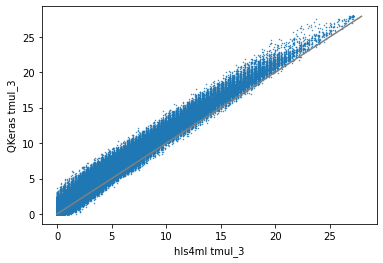

<Figure size 432x288 with 0 Axes>

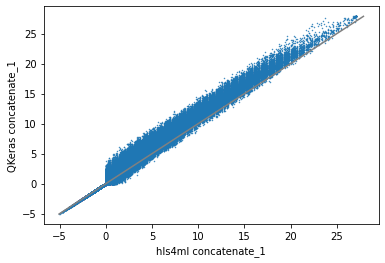

<Figure size 432x288 with 0 Axes>

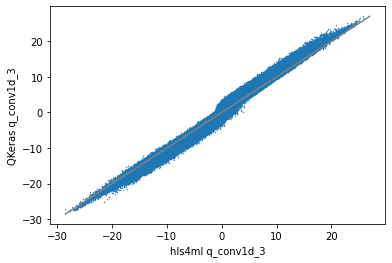

<Figure size 432x288 with 0 Axes>

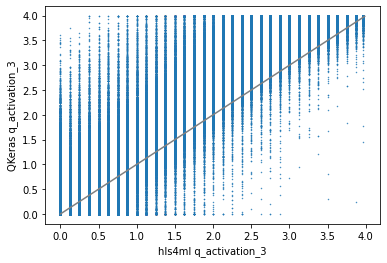

<Figure size 432x288 with 0 Axes>

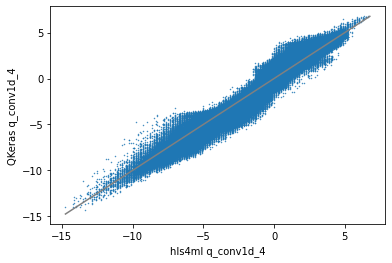

<Figure size 432x288 with 0 Axes>

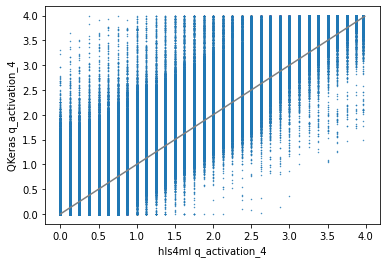

<Figure size 432x288 with 0 Axes>

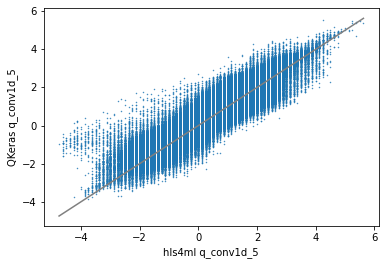

<Figure size 432x288 with 0 Axes>

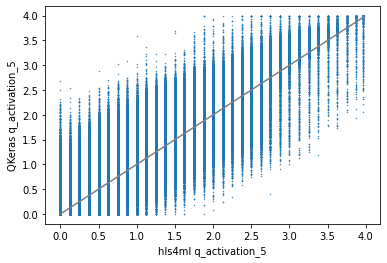

<Figure size 432x288 with 0 Axes>

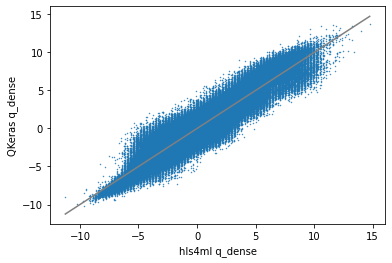

<Figure size 432x288 with 0 Axes>

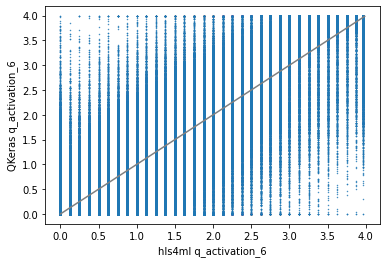

<Figure size 432x288 with 0 Axes>

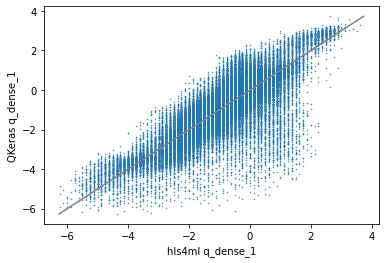

<Figure size 432x288 with 0 Axes>

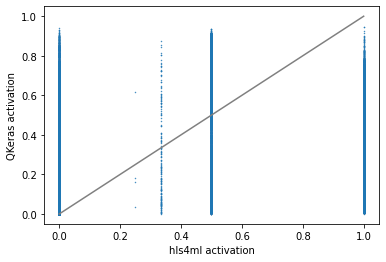

<Figure size 432x288 with 0 Axes>

In [119]:
import matplotlib
#%matplotlib inline
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
for i, layer in enumerate(hls_trace.keys()):
    plt.figure()
    min_x = min(np.amin(hls_trace[layer]), np.amin(keras_trace[layer]))
    max_x = max(np.amax(hls_trace[layer]), np.amax(keras_trace[layer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.scatter(hls_trace[layer].flatten(), keras_trace[layer].flatten(), s=0.2)
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(layer))
    plt.show()
    plt.savefig('profiling_{:02d}_{}.png'.format(i, layer), dpi=300)

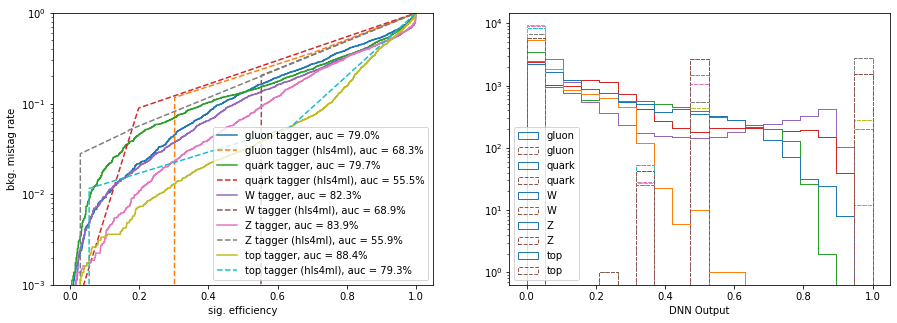

<Figure size 432x288 with 0 Axes>

In [120]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15,5))
ax = plt.subplot(1, 2, 1)

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
fpr_hls = {}
tpr_hls = {}
auc1_hls = {}
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,i])
        fpr_hls[label], tpr_hls[label], threshold_hls = roc_curve(Y_test[:,i], Y_hls[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        auc1_hls[label] = auc(fpr_hls[label], tpr_hls[label])
        ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
        ax.plot(tpr_hls[label],fpr_hls[label],label='%s tagger (hls4ml), auc = %.1f%%'%(label,auc1_hls[label]*100.),linestyle='dashed')
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
ax.legend(loc='lower right')


# Plot DNN output 
ax = plt.subplot(1, 2, 2)
X = np.linspace(0.0, 1.0, 20)
hist={}
hist_hls={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
    hist_hls[name] = ax.hist(Y_hls, bins=X, label=name ,histtype='step', linestyle='dashed')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
# Display plots
plt.show()
plt.savefig('results_hls4ml.pdf', dpi=300)
plt.savefig('results_hls4ml.png', dpi=300)

In [ ]:
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()